
<span style="text-decoration: underline;color:lightseagreen; font-weight:bold; font-size:xx-large;">CODES FOR P464-MHD COMPUTATION TERM PAPER</span>


<span style="color:teal; font-weight:bold; font-size:x-large;">Gayathri K</span>
</br>
<span style="color:teal; font-weight:bold; font-size:x-large;">2011067</span>



Importing the required libraries,

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


Defining all the constant parameters we are using, $\eta_t$ and h is kept constant as 1. We are using dimensionless units, the scales are specified wherever required.

In [ ]:
#parameters

eta = 1
h=1

omega_0=50
r_omega=15
alpha=0.5
alpha_cap=1

The grid parameters are as follows. 

In [ ]:
r_i = 0.01
r_f = 10.51
Nr = 200
T = 1
Nt = 9000

First we define the initial conditions and data structure for saving the field components. The initial conditions are chosen as a combination of sine waves, at the end this wont matter because the memory of seed field is lost in dynamo evolution. The values of field over all time and spatial points are stored in a 3-dimensional array, the dimensions being:  (time,component,space).

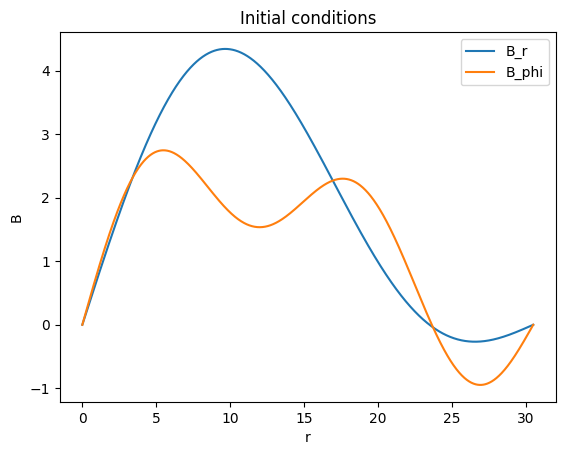

In [4]:
#initial conditions

# change the conditions

r = np.linspace(r_i, r_f, Nr)
def B_phi0(r):
    return 2*np.sin(((r - r_i)/(r_f - r_i))*np.pi)+np.sin(((r - r_i)/(r_f - r_i))*2*np.pi)+np.sin(((r - r_i)/(r_f - r_i))*4*np.pi)
def B_r0(r):    
    return (2*np.sin(((r - r_i)/(r_f - r_i))*2*np.pi)+3*np.sin(((r - r_i)/(r_f - r_i))*np.pi))

B_r = B_r0(r)
B_phi=B_phi0(r)

dt = T/Nt

plt.plot(r,B_r)
plt.xlabel('r')
plt.ylabel('B')
plt.plot(r,B_phi)
plt.legend(['B_r','B_phi'])
plt.title('Initial conditions')
plt.savefig('Initial_conditions_save.png')
plt.show()

# B_list = np.array([[B_r],[B_phi]])              #list to store B_r at each time step
# print(B_list.shape)
dr = r[1] - r[0]               #step size in r


schemes to find spatial derivatives

In [5]:
def spatial_derivative(B_r, B_phi,dr,ghost_zone_type,fd_order):

#GHOST ZONE HANDLING
    B_r=np.copy(B_r)
    B_phi=np.copy(B_phi)

    cell_needed = int(fd_order/2)
    if ghost_zone_type == 'symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect')
    elif ghost_zone_type == 'smooth':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect',reflect_type='odd')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect',reflect_type='odd')
    elif ghost_zone_type == 'anti-symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect') 
        for i in range(1,cell_needed+1):
            B_r[cell_needed-i] = -B_r[cell_needed-i]
            B_r[-cell_needed-1+i]=-B_r[-cell_needed-1+i]
            B_phi[cell_needed-i] = -B_phi[cell_needed-i]
            B_phi[-cell_needed-1+i]=-B_phi[-cell_needed-1+i]
      
    elif ghost_zone_type == 'relative anti-symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'constant')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'constant')
        for i in range (1,cell_needed+1):
            B_r[cell_needed-i] = 2*B_r[cell_needed] - B_r[cell_needed+i]
            B_r[-cell_needed-1+i]=2*B_r[-cell_needed-1] - B_r[-cell_needed-1-i]
            B_phi[cell_needed-i] = 2*B_phi[cell_needed] - B_phi[cell_needed+i]
            B_phi[-cell_needed-1+i]=2*B_phi[-cell_needed-1] - B_phi[-cell_needed-1-i]
    else:
        B_r = np.pad(B_r,(cell_needed,cell_needed),'constant')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'constant')

#FINITE DIFFERENCE
    
    if fd_order == 2:
        dB_r_dr = (-B_r[:-2] + B_r[1:])/(2*dr)
        dB_phi_dr = (-B_phi[:-2] + B_phi[1:])/(2*dr)
        d_sq_Br_dr = (B_r[:-2]-2*B_r[1:-1]+B_r[1:])/(dr**2)
        d_sq_Bphi_dr = (B_phi[:-2]-2*B_phi[1:-1]+B_phi[1:])/(dr**2)

    elif fd_order == 4:
        dB_r_dr = (B_r[:-4] - (8*B_r[1:-3]) + (8*B_r[3:-1]) - B_r[4:]) / (12*dr)
        dB_phi_dr = (B_phi[:-4] - (8*B_phi[1:-3]) + (8*B_phi[3:-1]) - B_phi[4:]) / (12*dr)
        d_sq_Br_dr = ((-B_r[:-4]) + (16*B_r[1:-3]) + (-30*B_r[2:-2]) + (16*B_r[3:-1]) (-B_r[4:])) / (12*(dr**2))
        d_sq_Bphi_dr = ((-B_phi[:-4]) + (16*B_phi[1:-3]) + (-30*B_phi[2:-2]) + (16*B_phi[3:-1]) (-B_phi[4:])) / (12*(dr**2))

    elif fd_order == 6:
        dB_r_dr = ((-B_r[:-6]) + (9 * B_r[1:-5]) - (45*B_r[2:-4]) + (45*B_r[4:-2]) - (9*B_r[5:-1]) + B_r[6:]) / (60*dr)
        dB_phi_dr = ((-B_phi[:-6]) + (9 * B_phi[1:-5]) - (45*B_phi[2:-4]) + (45*B_phi[4:-2]) - (9*B_phi[5:-1]) + B_phi[6:]) / (60*dr)
        d_sq_Br_dr = ((2*B_r[:-6]) - (27*B_r[1:-5]) + (270*B_r[2:-4]) - (490*B_r[3:-3]) + (270*B_r[4:-2]) - (27*B_r[5:-1]) + (2*B_r[6:])) / (180*(dr**2))
        d_sq_Bphi_dr = ((2*B_phi[:-6]) - (27*B_phi[1:-5]) + (270*B_phi[2:-4]) - (490*B_phi[3:-3]) + (270*B_phi[4:-2]) - (27*B_phi[5:-1]) + (2*B_phi[6:])) / (180*(dr**2))

    elif fd_order == 8:
        dB_r_dr = ((3*B_r[:-8]) - (32*B_r[1:-7]) + (168*B_r[2:-6]) - (672*B_r[3:-5]) + (672*B_r[5:-3]) - (168*B_r[6:-2]) + (32*B_r[7:-1]) - (3*B_r[8:])) / (840*dr)
        dB_phi_dr = ((3*B_phi[:-8]) - (32*B_phi[1:-7]) + (168*B_phi[2:-6]) - (672*B_phi[3:-5]) + (672*B_phi[5:-3]) - (168*B_phi[6:-2]) + (32*B_phi[7:-1]) - (3*B_phi[8:])) / (840*dr)
        d_sq_Br_dr = ((-9*B_r[:-8]) + (128*B_r[1:-7]) - (1008*B_r[2:-6]) + (8064*B_r[3:-5]) - (14350*B_r[4:-4]) + (8064*B_r[5:-3]) - (1008*B_r[6:-2]) + (128*B_r[7:-1]) - (9*B_r[8:])) / (5040*(dr**2))
        d_sq_Bphi_dr = ((-9*B_phi[:-8]) + (128*B_phi[1:-7]) - (1008*B_phi[2:-6]) + (8064*B_phi[3:-5]) - (14350*B_phi[4:-4]) + (8064*B_phi[5:-3]) - (1008*B_phi[6:-2]) + (128*B_phi[7:-1]) - (9*B_phi[8:])) / (5040*(dr**2))

    elif fd_order == 10:
        dB_r_dr = ((-2*B_r[:-10]) + (25*B_r[1:-9]) - (150*B_r[2:-8]) + (600*B_r[3:-7]) - (2100*B_r[4:-6]) + (2100*B_r[6:-4]) - (600*B_r[7:-3]) + (150*B_r[8:-2]) - (25*B_r[9:-1]) + (2*B_r[10:])) / (2520*dr)
        dB_phi_dr = ((-2*B_phi[:-10]) + (25*B_phi[1:-9]) - (150*B_phi[2:-8]) + (600*B_phi[3:-7]) - (2100*B_phi[4:-6]) + (2100*B_phi[6:-4]) - (600*B_phi[7:-3]) + (150*B_phi[8:-2]) - (25*B_phi[9:-1]) + (2*B_phi[10:])) / (2520*dr)
        d_sq_Br_dr = ((8*B_r[:-10]) - (125*B_r[1:-9]) + (1000*B_r[2:-8]) - (6000*B_r[3:-7]) + (42000*B_r[4:-6]) - (73766*B_r[5:-5]) + (42000*B_r[6:-4]) - (6000*B_r[7:-3]) + (1000*B_r[8:-2]) - (125*B_r[9:-1]) + (8*B_r[10:])) / (25200*(dr**2))
        d_sq_Bphi_dr = ((8*B_phi[:-10]) - (125*B_phi[1:-9]) + (1000*B_phi[2:-8]) - (6000*B_phi[3:-7]) + (42000*B_phi[4:-6]) - (73766*B_phi[5:-5]) + (42000*B_phi[6:-4]) - (6000*B_phi[7:-3]) + (1000*B_phi[8:-2]) - (125*B_phi[9:-1]) + (8*B_phi[10:])) / (25200*(dr**2))

    else:
        print('Invalid order of finite difference')
        return

    return dB_r_dr, dB_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr
       
        


In [6]:
def first_der(f_,dr,ghost_zone_type=None,order=6):
    #GHOST ZONE HANDLING

    cell_needed = int(order/2)
    if ghost_zone_type == 'symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
       
    elif ghost_zone_type == 'smooth':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect',reflect_type='odd')
    elif ghost_zone_type == 'anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
        for i in range(1,cell_needed+1):
            f_[cell_needed-i] = -f_[cell_needed-i]
            f_[-cell_needed-1+i]=-f_[-cell_needed-1+i]
      
        
    elif ghost_zone_type == 'relative anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')
        for i in range (1,cell_needed+1):
            f_[cell_needed-i] = 2*f_[cell_needed] - f_[cell_needed+i]
            f_[-cell_needed-1+i]=2*f_[-cell_needed-1] - f_[-cell_needed-1-i]
    else:
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')

    #FINITE DIFFERENCE
    if order == 2:
        df__dr = (-f_[:-2] + f_[1:])/(2*dr)
    
    elif order == 4:
        df__dr = (f_[:-4] - (8*f_[1:-3]) + (8*f_[3:-1]) - f_[4:]) / (12*dr)

    elif order == 6:
        df__dr = ((-f_[:-6]) + (9 * f_[1:-5]) - (45*f_[2:-4]) + (45*f_[4:-2]) - (9*f_[5:-1]) + f_[6:]) / (60*dr)

    elif order == 8:
        df__dr = ((3*f_[:-8]) - (32*f_[1:-7]) + (168*f_[2:-6]) - (672*f_[3:-5]) + (672*f_[5:-3]) - (168*f_[6:-2]) + (32*f_[7:-1]) - (3*f_[8:])) / (840*dr)
    
    elif order == 10:
        df__dr = ((-2*f_[:-10]) + (25*f_[1:-9]) - (150*f_[2:-8]) + (600*f_[3:-7]) - (2100*f_[4:-6]) + (2100*f_[6:-4]) - (600*f_[7:-3]) + (150*f_[8:-2]) - (25*f_[9:-1]) + (2*f_[10:])) / (2520*dr)
        
    else:
        print('Invalid order of finite difference')
        return

    return df__dr
       


In [7]:
omega = omega_0*(1 + (r/r_omega)**2)**(-1/2)
neg_q_omega=(r)*(first_der(omega,dr,ghost_zone_type='smooth',order=6))
#q=-(r/omega)*(first_der(omega,dr,ghost_zone_type='smooth',order=6))
R_alpha=alpha*h/eta
R_omega=neg_q_omega*(h**2)/eta
D=R_alpha*R_omega


In [8]:


def dB_r_dt(B_r,B_phi,db_r_dr,d_sq_Br_dr,dt):
    return (- (np.pi/(2*h)) * R_alpha *alpha_cap* B_phi) + (eta * (d_sq_Br_dr + (db_r_dr / r) - (B_r/(r ** 2)) - (((np.pi * 2) / (4 * (h**2))) * B_r)))
def dB_phi_dt(B_phi,B_r,db_phi_dr,d_sq_Bphi_dr,dt):
    return (R_omega * B_r) + (eta * (d_sq_Bphi_dr + (db_phi_dr / r) - (B_phi/(r ** 2)) - (((np.pi * 2) / (4 * (h**2))) * B_phi)))

coupled RK4

In [9]:
def RK4(B_r,B_phi,dt,dr,ghost_zone_type='anti-symmetric'):
   B_list = [[B_r],[B_phi]]            #list to store B_r at each time step

   m=ghost_zone_type
   for i in tqdm(range(Nt)):
        
      db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r, B_phi,dr,m,6)
      
      k1_r = dB_r_dt(B_r,B_phi,db_r_dr,d_sq_Br_dr,i*dt)
      k1_phi = dB_phi_dt(B_phi,B_r,db_phi_dr,d_sq_Bphi_dr,i*dt)

      k2_r = dB_r_dt(B_r + 0.5*dt*k1_r,B_phi + 0.5*dt*k1_phi,db_r_dr,d_sq_Br_dr,i*dt + 0.5*dt)
      k2_phi = dB_phi_dt(B_phi + 0.5*dt*k1_phi,B_r + 0.5*dt*k1_r,db_phi_dr,d_sq_Bphi_dr,i*dt + 0.5*dt)

      k3_r = dB_r_dt(B_r + 0.5*dt*k2_r,B_phi + 0.5*dt*k2_phi,db_r_dr,d_sq_Br_dr,i*dt + 0.5*dt)
      k3_phi = dB_phi_dt(B_phi + 0.5*dt*k2_phi,B_r + 0.5*dt*k2_r,db_phi_dr,d_sq_Bphi_dr,i*dt + 0.5*dt)

      k4_r = dB_r_dt(B_r + dt*k3_r,B_phi + dt*k3_phi,db_r_dr,d_sq_Br_dr,i*dt + dt)
      k4_phi = dB_phi_dt(B_phi + dt*k3_phi,B_r + dt*k3_r,db_phi_dr,d_sq_Bphi_dr,i*dt + dt)

      B_r = B_r + (dt/6)*(k1_r + 2*k2_r + 2*k3_r + k4_r)
      B_phi = B_phi + (dt/6)*(k1_phi + 2*k2_phi + 2*k3_phi + k4_phi)
      
      B_list[0].append(B_r)
      B_list[1].append(B_phi)
   B_list=np.array(B_list)
   return B_list

In [10]:
B_list_antisymm = RK4(B_r,B_phi,dt,dr,ghost_zone_type='anti-symmetric')
# B_list_symm= RK4(B_r,B_phi,dt,dr,ghost_zone_type='symmetric')
# B_list_smooth= RK4(B_r,B_phi,dt,dr,ghost_zone_type='smooth')
# B_list_relanti= RK4(B_r,B_phi,dt,dr,ghost_zone_type='relative anti-symmetric')



  0%|          | 435/150000 [00:00<04:42, 528.83it/s]

100%|██████████| 150000/150000 [03:53<00:00, 641.13it/s]


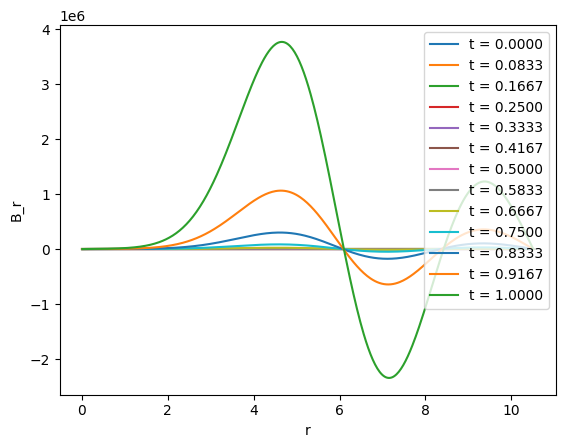

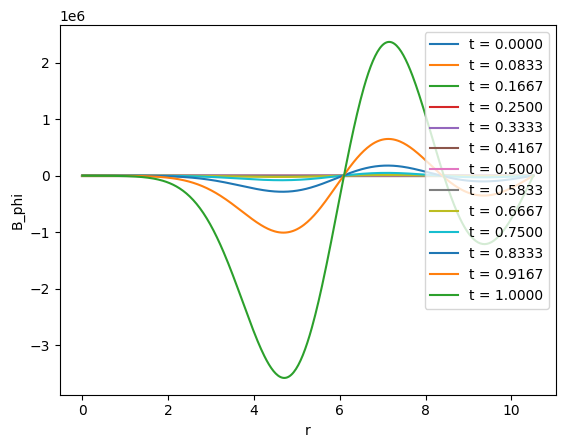

In [ ]:
for i in [i for i in range(0,Nt+1,500)]:  
    plt.plot(r,B_list_antisymm[0][i],label=f't = {i*dt:.4f}')
plt.xlabel('r')
plt.ylabel('B_r')
plt.savefig('B_r_antisymm_save.png')
plt.legend()
plt.show()

for i in [i for i in range(0,Nt+1,500)]:  
    plt.plot(r,B_list_antisymm[1][i],label=f't = {i*dt:.4f}')
plt.xlabel('r')
plt.ylabel('B_phi')
plt.legend()
plt.savefig('B_phi_antisymm_save.png')
plt.show()






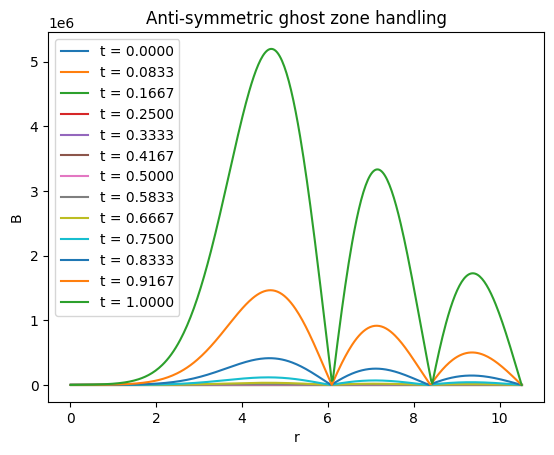

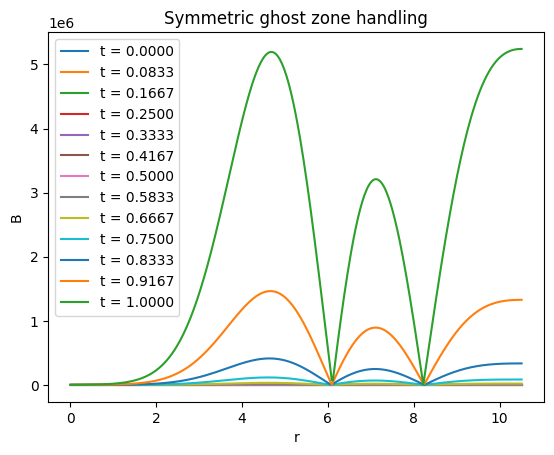

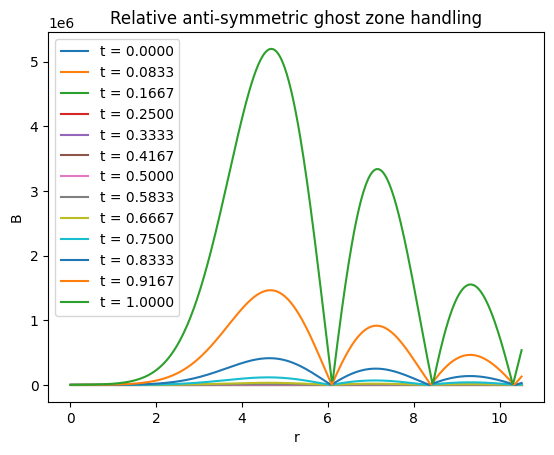

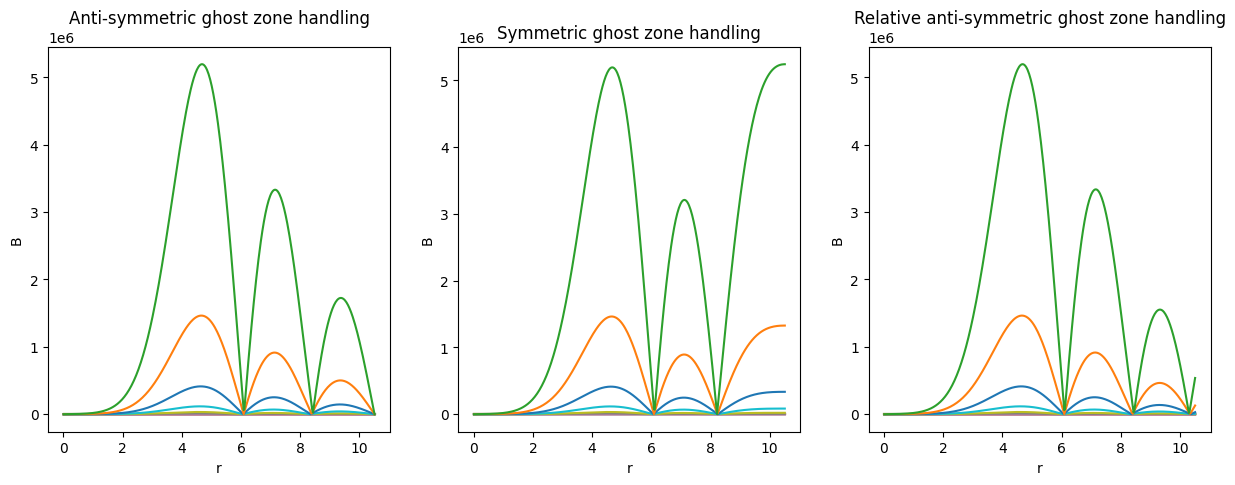

In [ ]:
# Calculate magnitude of magnetic field
B_list_strength = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_antisymm[0], B_list_antisymm[1])]
#B_list_symm_strength = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_symm[0], B_list_symm[1])]
# B_list_smooth_strength = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_smooth[0], B_list_smooth[1])]
# B_list_anti_strength = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_relanti[0], B_list_relanti[1])]

# Ensure r and B_list_strength have the same length
r = r[:len(B_list_strength)]
plt.figure()
for i in [i for i in range(0,Nt+1,500)]:  
    plt.plot(r,B_list_strength[i],label=f't = {i*dt:.4f}')
    
plt.xlabel('r')
plt.ylabel('B')
plt.legend()
plt.savefig('B_rel-antisymm_save.png')
plt.title('Anti-symmetric ghost zone handling')
plt.show()
#same for symmetric
#plt.figure()
# for i in [i for i in range(0,Nt+1,500)]:  
#     plt.plot(r,B_list_symm_strength[i],label=f't = {i*dt:.4f}')
# plt.xlabel('r')
# plt.ylabel('B')
# plt.legend()
# plt.title('Symmetric ghost zone handling')
# plt.savefig('B_symm_save.png')
# plt.show()
# #same for smooth

# plt.figure()
# for i in [i for i in range(0,Nt+1,500)]:  
#     plt.plot(r,B_list_anti_strength[i],label=f't = {i*dt:.4f}')
# plt.xlabel('r')
# plt.ylabel('B')
# plt.legend()
# plt.title('Relative anti-symmetric ghost zone handling')
# plt.savefig('B_anti_save.png')
# plt.show()


# plt.show()


# #now plot these three side by side
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for i in [i for i in range(0,Nt+1,500)]:  
#     axs[0].plot(r,B_list_strength[i],label=f't = {i*dt:.4f}')
#     axs[1].plot(r,B_list_symm_strength[i],label=f't = {i*dt:.4f}')
#     # axs[2].plot(r,B_list_anti_strength[i],label=f't = {i*dt:.4f}')
# axs[0].set_title('Anti-symmetric ghost zone handling')
# axs[1].set_title('Symmetric ghost zone handling')
# axs[2].set_title('Relative anti-symmetric ghost zone handling')
# axs[0].set_xlabel('r')
# axs[1].set_xlabel('r')
# axs[2].set_xlabel('r')
# axs[0].set_ylabel('B')
# axs[1].set_ylabel('B')
# axs[2].set_ylabel('B')
# plt.savefig('B_all_save.png')
# plt.show()
# #make an animation


# animate using matplotlib
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(r_i, r_f)
ax.set_ylim(-1, 1)
ax.set_xlabel('Radius (r)')
ax.set_ylabel('Magnetic Field (B)')
ax.set_title('Evolution of Magnetic Field with Time')
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = r
    y = B_list_strength[i]
    line.set_data(x, y)
    ax.set_title(f'Time Step {i+1}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=int(Nt/2), init_func=init, blit=True)
ani.save('long gif 1.gif', writer='pillow')

# plt.show()


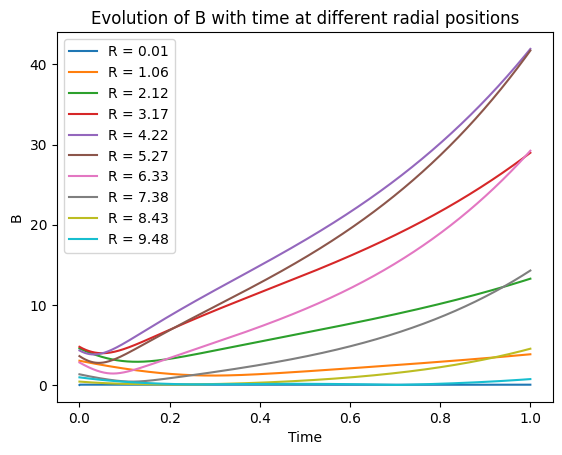

In [ ]:


# Calculate the evolution of magnetic field at different radial positions

# Store the evolution of magnetic field at different radial positions
evolution_Br = np.zeros((Nt + 1, Nr))
evolution_Bphi = np.zeros((Nt + 1, Nr))
for i in range(Nt + 1):
    evolution_Br[i] = B_list_antisymm[0][i]
    evolution_Bphi[i] = B_list_antisymm[1][i]



#now plot the strength in same way
evolution_B = np.sqrt(evolution_Br**2 + evolution_Bphi**2)

for i in range(0, Nr, Nr // 10):  # Plot every 10th radial position
    plt.plot(np.linspace(0, T, Nt + 1), evolution_B[:, i], label=f'R = {r[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('B')
plt.title('Evolution of B with time at different radial positions')
plt.savefig('B_evolution_radial.png')
plt.legend()
plt.show()




In [ ]:
B_list_strength = np.array(B_list_strength)
print(B_list_strength.shape)

(6001, 400)


m = 1.13433438497302, c = 0.5727081079980864


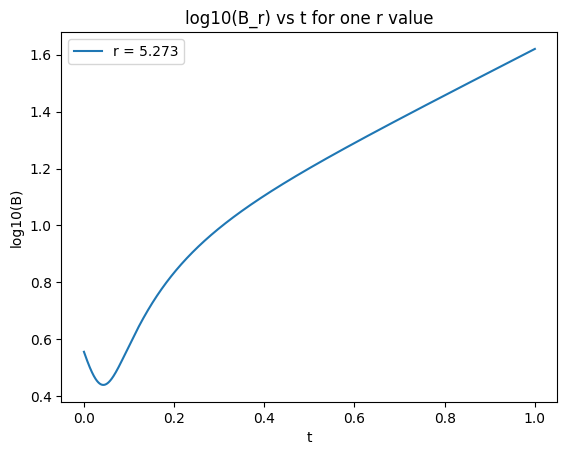

In [ ]:
from scipy.stats import linregress

# Assuming B_list_t and r are defined
B_list_t = np.transpose(B_list_strength)
t_list = np.linspace(0, T, Nt+1)

index = int(200)

plt.plot(t_list, np.log10(B_list_t[index][0:]), label=f'r = {r[index]:.3f}')
m, c = np.polyfit(t_list, np.log10(B_list_t[index][0:]), 1)
print(f"{m = }, {c = }")

plt.xlabel('t')
plt.ylabel('log10(B)')
plt.legend()
plt.title('log10(B_r) vs t for one r value')
plt.savefig('log10(B_r)_vs_t_alpha1.png')
plt.show()


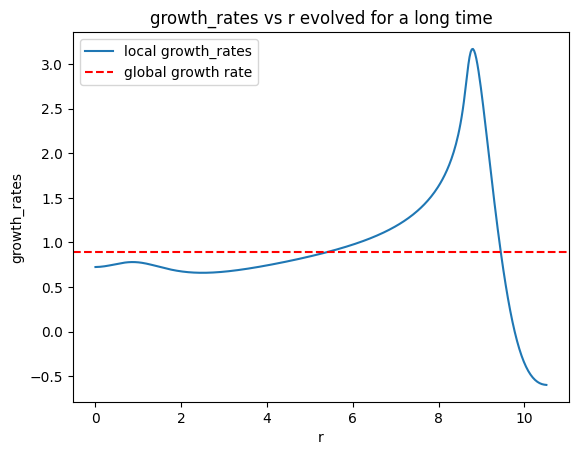

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming B_list_mag, T, and r are defined
B_list_final = np.transpose(B_list_strength)
t_list = np.linspace(0, T, Nt+1)
cutoff_index = int(Nt*0.3)
# Function to calculate slope for each value of r
def calculate_slope(B_list_final, t_list):
    slopes = []
    for index in range(len(r)):
        # Fit a linear polynomial (line) to the log-transformed data
        coefficients = np.polyfit(t_list[cutoff_index:], np.log10(B_list_final[index][cutoff_index:]), 1)
        # Extract slope
        slope = coefficients[0]
        slopes.append(slope)
    return slopes

slopes = calculate_slope(B_list_final, t_list)
slopes = np.array(slopes)

growth_rates = slopes
plt.plot(r, growth_rates)
#a horizontal line ay y=0.89
plt.axhline(y=0.89, color='r', linestyle='--')
plt.legend(['local growth_rates','global growth rate'])
plt.xlabel('r')
plt.ylabel('growth_rates')
plt.title('growth_rates vs r evolved for a long time')
plt.savefig('growth_rates_vs_r_alpha1.png')
#now find the r value where growth rate peaks and mark it
# max_index = np.argmax(growth_rates)
# #add a vertical line to show the peak and label the r value
# #add a text to show the r value
# t_d = 1
# Dc = - (np.pi ** 2) / 32
# local_gamma_theoretical = (np.sqrt(2 / np.pi) / t_d) * (np.sqrt(-D) - np.sqrt(-Dc))
# plt.plot(r,local_gamma_theoretical)
# plt.xlabel('r')
# plt.legend(['global growth rate','Theoretical local growth rates'])
# plt.show()
# global_growth_rate=np.mean(growth_rates)
# print(global_growth_rate)
#add a text to show the r value


In [ ]:
#theoretical value


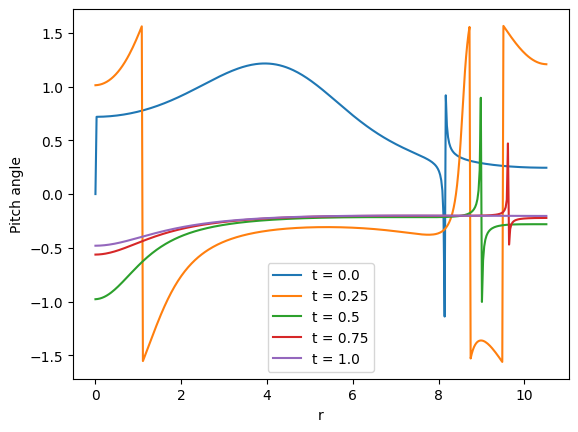

In [ ]:

# Calculate pitch angle
pitch_angles = [np.arctan2(B_r, B_phi) for B_r, B_phi in zip(B_list_antisymm[0], B_list_antisymm[1])]

#plotting
#pitch angle have to be between -pi/2 and pi/2
for i in [i for i in range(0,Nt+1,1500)]:
    
    y = np.where(pitch_angles[i] > np.pi / 2, pitch_angles[i] - np.pi, pitch_angles[i])
    y = np.where(y <= -np.pi / 2, y + np.pi, y)
    plt.plot(r, y, label='t = '+str(i*dt))
plt.xlabel('r')
plt.ylabel('Pitch angle')
plt.legend()
plt.show()


# fig, ax = plt.subplots()
# ax.set_xlim(r_i, r_f)
# ax.set_ylim(np.min(pitch_angles), np.max(pitch_angles))
# ax.set_xlabel('Radius (r)')
# ax.set_ylabel('Pitch angle')
# ax.set_title('Evolution of pitch angle in time')

# line, = ax.plot([], [], lw=2)

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):
#     x = r
#     # Ensure pitch angle is within the range -pi/2 < p <= pi/2
#     y = np.where(pitch_angles[i] > np.pi / 2, pitch_angles[i] - np.pi, pitch_angles[i])
#     y = np.where(y <= -np.pi / 2, y + np.pi, y)
#     line.set_data(x, y)
#     ax.set_title(f'Time Step {i+1}/{len(B_list_strength)}')
#     return line,

# ani = animation.FuncAnimation(fig, animate, frames=len(B_list_strength), init_func=init, blit=True)
# ani.save('pitch1_final_savv.gif', writer='ffmpeg', fps=30)

# plt.show()


Different seed fields

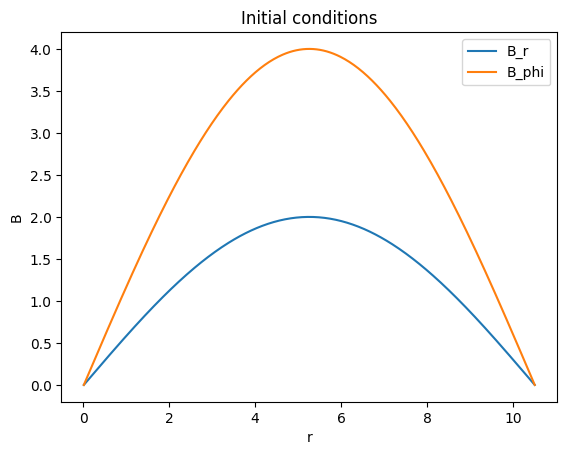

  0%|          | 0/6000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (2,7,406) (400,) 

In [ ]:
#change the initial condition and plot strength again
#parameters
def B_phi0_new(r):
    return 4*np.sin((r-r_i)/(r_f-r_i)*np.pi)
def B_r0_new(r):    
    return 2*np.sin((r-r_i)/(r_f-r_i)*np.pi)
# def B_phi0(r):
#     return (3 * np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1 * np.sin(((r - r_i)/(r_f - r_i))*2*np.pi)) + (2 * np.sin(((r - r_i)/(r_f - r_i))*5*np.pi))
# def B_r0(r):
#     return (3 * np.sin(((r - r_i)/(r_f - r_i))*4*np.pi)) + (1 * np.sin(((r - r_i)/(r_f - r_i))*2*np.pi)) + (2 * np.sin(((r - r_i)/(r_f - r_i))*3*np.pi))
B_r_new = B_r0_new(r)
B_phi_new=B_phi0_new(r)



plt.plot(r,B_r_new)
plt.xlabel('r')
plt.ylabel('B')
plt.plot(r,B_phi_new)
plt.legend(['B_r','B_phi'])
plt.title('Initial conditions')
plt.savefig('Initial_conditions_2.png')
plt.show()

B_list_new = np.array([[B_r_new],[B_phi_new]])              #list to store B_r at each time step

B_list_new = RK4(B_list_new,B_r_new,B_phi_new,dt,dr)
B_list_strength_new = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_new[0], B_list_new[1])]

# Ensure r and B_list_strength have the same length
r = r[:len(B_list_strength)]
for i in [i for i in range(0,Nt+1,500)]:  
    plt.plot(r,B_list_strength_new[i],label='t = '+str(i*dt))
plt.xlabel('r')
plt.ylabel('B')
plt.legend()
plt.savefig('B_alpha1_newic.png')
plt.show()

In [ ]:
def B_phi0_new_1(r):
    return np.sin((r-r_i)/(r_f-r_i)*np.pi)+np.sin((r-r_i)/(r_f-r_i)*2*np.pi)+np.sin((r-r_i)/(r_f-r_i)*4*np.pi)
def B_r0_new_1(r):    
    return np.sin((r-r_i)/(r_f-r_i)*2*np.pi)+np.sin(5*(r-r_i)/(r_f-r_i)*np.pi)
#do the same here
B_r_new_1 = B_r0_new_1(r)
B_phi_new_1=B_phi0_new_1(r)
#add these to a new blist
B_list_new_1 = np.array([[B_r_new_1],[B_phi_new_1]])              #list to store B_r at each time step
#do rk4
B_list_new_1 = RK4(B_list_new_1,B_r_new_1,B_phi_new_1,dt,dr)
B_list_strength_new_1 = [np.sqrt(B_r**2 + B_phi**2) for B_r, B_phi in zip(B_list_new_1[0], B_list_new_1[1])]
# Ensure r and B_list_strength have the same length
r = r[:len(B_list_strength)]
for i in [i for i in range(0,Nt+1,500)]:  
    plt.plot(r,B_list_strength_new_1[i],label='t = '+str(i*dt))
plt.xlabel('r')
plt.ylabel('B')
plt.legend()
plt.savefig('B_alpha1_newic_1.png')
plt.show()



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.

different boundary conditions